In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# your function must import layout and constants
# this is structured to work both in Jupyter notebook and from the command line
try:
    from . import layout
    from . import constants
except ImportError:
    import layout
    import constants
    
from datetime import datetime
from pathlib import Path
import shutil
import socket
import psutil

In [89]:
def _temperature():
    '''return a dictionary with the current CPU temperature on a raspberry pi in degrees C'''
    try:
        f = psutil.sensors_temperatures()
        current = f['cpu_thermal'][0].current
    except psutil.Error as e:
        logging.error(f'could not get CPU temperature: {e}')
        current = 0
    
    current = int(round(current,0))
    
    current = f'Temp: {current}C'
    
    return {'cputemp': current}

In [87]:
def _cpu_load():
    '''return a dicionary containing a list of the load average for 
    all cpus for 1, 5, 15 minutes as percentages'''
    try:
        load = [f'{round(x / psutil.cpu_count() * 100, 2)}%' for x in psutil.getloadavg()]
    except psutil.Error as e:
        logging.error(f'CPU info not available: {e}')
        load = ('NA', 'NA', 'NA')
        
    
        
    return {
        'cpuload_5': f'5 min: {load[0]}',
        'cpuload_10': f'10 min: {load[1]}',
        'cpuload_15': f'15 min: {load[2]}'
    }

In [5]:
def _network_info():
    '''return a dictionary containing the hostname and ipaddress of the host'''
    try:
        hostname = socket.gethostname()
    except OSError as e:
        logging.error(f'could not get hostname: {e}')
        hostname = 'UNKNOWN!'
    
    # based on https://stackoverflow.com/a/28950776/5530152
    s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    s.settimeout(0)
    try:
        # doesn't even have to be reachable
        s.connect(('10.254.254.254', 1))
        IP = s.getsockname()[0]
    except Exception:
        IP = '127.0.0.1'
    finally:
        s.close()
    
    return {
        'hostname': hostname,
        'ipaddress': IP
    }

In [50]:
def _disk_use(unit='GB', rounding=0 ):
    '''return a diciontary containing 
        disk_total, diskuse, diskfree in units and percentages'''
    try:
        total_b, used_b, free_b = shutil.disk_usage("/")
    except OSError as e:
        logging.error(f'could not access "/": {e}')
        total_b, used_b, free_b = 0, 0, 0
    
    if unit not in constants.storage_units.keys():
        logging.warning(f'unknown storage unit in config: "{unit}"; falling back to `GB`')
    
    my_unit = constants.storage_units.get(unit, 10**9)
    
    return {
        'disk_total': f"Total: {int(round(total_b/my_unit, 0))} {unit}",
        'diskuse': f"Used: {int(round(used_b/my_unit, 0))} {unit}",
        'diskfree': f"Free: {int(round(used_b/my_unit, 0))} {unit}",
        # prevent div/0 errors by adding 1 byte
        'diskuse_pct': f'Used: {int(round(used_b/(total_b+1)*100, 0))}%',
        'diskfree_pct': f'Free: {int(round(free_b/(total_b+1)*100, 0))}%',
        'disk_units': unit,
    }

In [54]:
# make sure this function can accept *args and **kwargs even if you don't intend to use them
def update_function(self, *args, **kwargs):
    '''update function to display system information
    
    Requirments:
        self.config(dict): {
        }
        
    Args: 
        self(namespace): namespace from plugin object
    
    Returns:
        tuple: (is_updated(bool), data(dict), priority(int))

    %U'''   
    
    is_updated = True
    data = {}
    priority = self.max_priority
    
    data.update(_network_info())
    data.update(_disk_use())
    data.update(_cpu_load())
    data.update(_temperature())
    data['time'] = datetime.now().strftime("%H:%M")
    data['disk_icon'] = './images/hdd.jpg'
    data['cpu_icon'] = './images/chip.jpg'
    

    
    
    return (is_updated, data, priority)

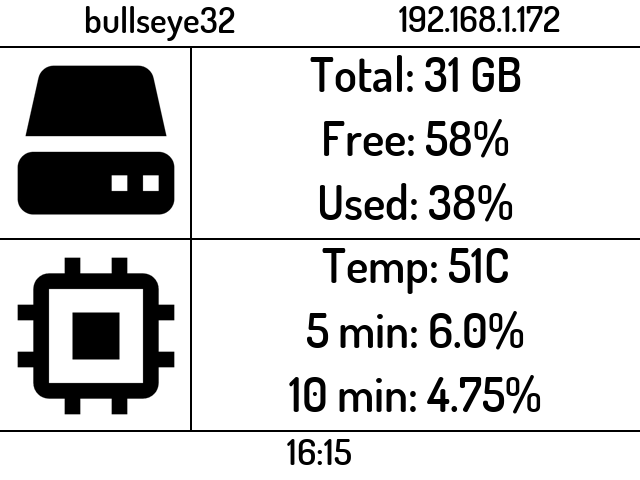

In [96]:
# this code snip simulates running from within the display loop use this and the following
# cell to test the output
# fugly hack for making the library module available to the plugins
import sys
sys.path.append(layout.dir_path+'/../..')
from library import PluginTools
import logging
logging.root.setLevel('WARNING')
from library.CacheFiles import CacheFiles
from library.Plugin import Plugin
from IPython.display import display
test_plugin = Plugin(resolution=(0, 0))
test_plugin = Plugin(resolution=(640, 480), screen_mode='L')
test_plugin.config = {
    'text_color': 'random',
    'bkground_color': 'White',
}
test_plugin.refresh_rate = 5
# l = layout.layout
test_plugin.layout = basic_layout
# test_plugin.cache = CacheFiles()
test_plugin.update_function = update_function
test_plugin.update()
test_plugin.image

In [95]:
dir_path = layout.dir_path
basic_layout = {
      'hostname': {
         'type': 'TextBlock',  
         'mode': 'L',          
         'image': False,
         'max_lines': 1,
         'width': .5,
         'height': .1,
         'font': dir_path+'/../../fonts/Dosis/static/Dosis-SemiBold.ttf',
         # X, Y coordinate is absolute
         'abs_coordinates': (0, 0),
         # Use X from 'time', Y from the bottom of 'string'
         'fill': 'BLACK',
         'bkground': 'WHITE',
         'padding': 2,
         'hcenter': True,
         'vcenter': True,
         'align': 'center',
         'border_config': {'fill': 0, 'width': 2, 'sides': ['bottom']}
  },
     'ipaddress': {
         'type': 'TextBlock',
         'mode': 'L',
         'image': False,
         'max_lines': 1,
         'width': .5,
         'height': .1,
         'font': dir_path+'/../../fonts/Dosis/static/Dosis-SemiBold.ttf',
         'abs_coordinates': (None, 0),
         'relative': ['hostname', 'ipaddress'],
         'fill': 'black',
         'bkground': 'white',
         'padding': 2,
         'hcenter': True,
         'vcenter': True,
         'align': 'center',
         'border_config': {'fill': 0, 'width': 2, 'sides': ['bottom']}
     },
     'disk_icon': {
         'type': 'ImageBlock',
         'mode': 'L',
         'width': .3,
         'height': .399,
         'abs_coordinates': (0, None),
         'relative': ['disk_icon', 'hostname'],
         'padding': 2,
         'hcenter': True,
         'vcenter': True,
         'border_config': {'fill': 0, 'width': 2, 'sides': ['right', 'bottom']}
     },
     'disk_total': {
         'type': 'TextBlock',
         'mode': 'L',
         'image': False,
         'max_lines': 1,
         'width': .7,
         'height': .133,
         'font': dir_path+'/../../fonts/Dosis/static/Dosis-SemiBold.ttf',
         'abs_coordinates': (None, None),
         'relative': ['disk_icon', 'ipaddress'],
         'fill': 'black',
         'bkground': 'white',
         'padding': 2,
         'hcenter': True,
         'vcenter': True,
         'align': 'center',
#          'border_config': {'fill': 0, 'width': 2, 'sides': ['bottom']}
     },
     'diskfree_pct': {
         'type': 'TextBlock',
         'mode': 'L',
         'image': False,
         'max_lines': 1,
         'width': .7,
         'height': .133,
         'font': dir_path+'/../../fonts/Dosis/static/Dosis-SemiBold.ttf',
         'abs_coordinates': (None, None),
         'relative': ['disk_icon', 'disk_total'],
         'fill': 'black',
         'bkground': 'white',
         'padding': 2,
         'hcenter': True,
         'vcenter': True,
         'align': 'center',
#          'border_config': {'fill': 0, 'width': 2, 'sides': ['bottom']}
     },    
     'diskuse_pct': {
         'type': 'TextBlock',
         'mode': 'L',
         'image': False,
         'max_lines': 1,
         'width': .7,
         'height': .133,
         'font': dir_path+'/../../fonts/Dosis/static/Dosis-SemiBold.ttf',
         'abs_coordinates': (None, None),
         'relative': ['disk_icon', 'diskfree_pct'],
         'fill': 'black',
         'bkground': 'white',
         'padding': 2,
         'hcenter': True,
         'vcenter': True,
         'align': 'center',
         'border_config': {'fill': 0, 'width': 2, 'sides': ['bottom']}
     }, 
     'cpu_icon': {
         'type': 'ImageBlock',
         'mode': 'L',
         'width': .3,
         'height': .399,
         'abs_coordinates': (0, None),
         'relative': ['cpu_icon', 'disk_icon'],
         'padding': 2,
         'hcenter': True,
         'vcenter': True,
         'border_config': {'fill': 0, 'width': 2, 'sides': ['right', 'bottom']}
     },
    'cputemp': {
         'type': 'TextBlock',
         'mode': 'L',
         'image': False,
         'max_lines': 1,
         'width': .7,
         'height': .133,
         'font': dir_path+'/../../fonts/Dosis/static/Dosis-SemiBold.ttf',
         'abs_coordinates': (None, None),
         'relative': ['cpu_icon', 'diskuse_pct'],
         'fill': 'black',
         'bkground': 'white',
         'padding': 2,
         'hcenter': True,
         'vcenter': True,
         'align': 'center',
#          'border_config': {'fill': 0, 'width': 2, 'sides': ['bottom']} 
    },
    'cpuload_5': {
         'type': 'TextBlock',
         'mode': 'L',
         'image': False,
         'max_lines': 1,
         'width': .7,
         'height': .133,
         'font': dir_path+'/../../fonts/Dosis/static/Dosis-SemiBold.ttf',
         'abs_coordinates': (None, None),
         'relative': ['cpu_icon', 'cputemp'],
         'fill': 'black',
         'bkground': 'white',
         'padding': 2,
         'hcenter': True,
         'vcenter': True,
         'align': 'center',
#          'border_config': {'fill': 0, 'width': 2, 'sides': ['bottom']} 
    },
    'cpuload_10': {
         'type': 'TextBlock',
         'mode': 'L',
         'image': False,
         'max_lines': 1,
         'width': .7,
         'height': .133,
         'font': dir_path+'/../../fonts/Dosis/static/Dosis-SemiBold.ttf',
         'abs_coordinates': (None, None),
         'relative': ['cpu_icon', 'cpuload_5'],
         'fill': 'black',
         'bkground': 'white',
         'padding': 2,
         'hcenter': True,
         'vcenter': True,
         'align': 'center',
         'border_config': {'fill': 0, 'width': 2, 'sides': ['bottom']} 
    }, 
    'time': {
         'type': 'TextBlock',
         'mode': 'L',
         'image': False,
         'max_lines': 1,
         'width': 1,
         'height': .102,
         'font': dir_path+'/../../fonts/Dosis/static/Dosis-SemiBold.ttf',
         'abs_coordinates': (0, None),
         'relative': ['time', 'cpu_icon'],
         'fill': 'black',
         'bkground': 'white',
         'padding': 2,
         'hcenter': True,
         'vcenter': True,
         'align': 'center',
#          'border_config': {'fill': 0, 'width': 2, 'sides': ['bottom']} 
    },      


}

In [ ]:
# # this simulates running your plugin from within paperpi
# my_plugin()

In [ ]:
# run this snip to create a symbolic to enable loading libraries for testing
!ln -s ../../library

In [ ]:
!jupyter-nbconvert --to python --template python_clean system_info.ipynb